In [1]:
import numpy as np 
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import copy 
import pandas as pd
import time
import datetime

from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
np.random.seed(7)

Using TensorFlow backend.


# Data Preprocessing

In [2]:
    Dataset = r'15minute_data_newyork\15minute_data_newyork.csv'
    fulldata = pd.read_csv(Dataset) 

In [3]:
data=fulldata[['dataid','local_15min','grid']]

In [4]:
sorteddata=data.sort_values(by = ['dataid', 'local_15min'])

In [5]:
ids=sorteddata['dataid'].unique().tolist()

In [6]:
housing_data = []
def convertDate(d):
    d = pd.to_datetime(d[:-3])
    return d 

for i in range(len(ids)):
    housing_data.append(sorteddata.loc[sorteddata.dataid==ids[i]])
    housing_data[i] = housing_data[i].reset_index().drop(columns=['index'])
    housing_data[i]['local_15min'] = housing_data[i]['local_15min'].apply(convertDate)
    #Convert datetimes to ints for regession 
    housing_data[i]['15min_ints'] =  housing_data[i]['local_15min'].map(mdates.date2num)

In [7]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)


In [8]:
#set up
dataframe = housing_data[0]['grid']
dataset = np.matrix(dataframe.values).transpose()
dataset = dataset.astype('float32')

In [9]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [10]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:,:]

In [11]:
# reshape into X=t and Y=t+look_back
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [12]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

# LSTM

https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

In [13]:
# create and fit the LSTM network
# model = Sequential()
# model.add(LSTM(4, input_shape=(look_back, 1)))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error', optimizer='adam')
# model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)

In [14]:
#save or load
# model.save('0house_model.h5')
model = load_model('0house_model.h5')

In [15]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [16]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [17]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.92 RMSE
Test Score: 0.84 RMSE


In [18]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

In [19]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(dataset), :] = testPredict

In [20]:
print(testPredict.shape)
print(testX.shape)

(5826, 1)
(5826, 3, 1)


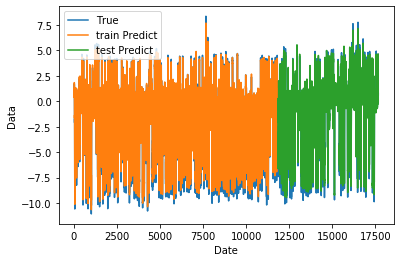

In [21]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset), label= 'True' )
plt.plot(trainPredictPlot, label= 'train Predict')
plt.plot(testPredictPlot, label= 'test Predict')
plt.xlabel('Date')
plt.ylabel('Data')
plt.legend()
plt.show()


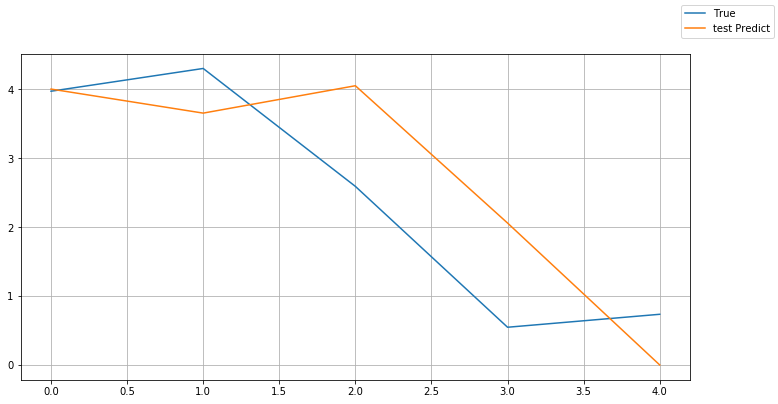

In [22]:
#check last values
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(scaler.inverse_transform(dataset)[-5:], label= 'True' )
# plt.plot(trainPredictPlot, label= 'train Predict')
ax.plot(testPredictPlot[-5:], label= 'test Predict')
ax.grid(True)
fig.legend()

# ax.show()

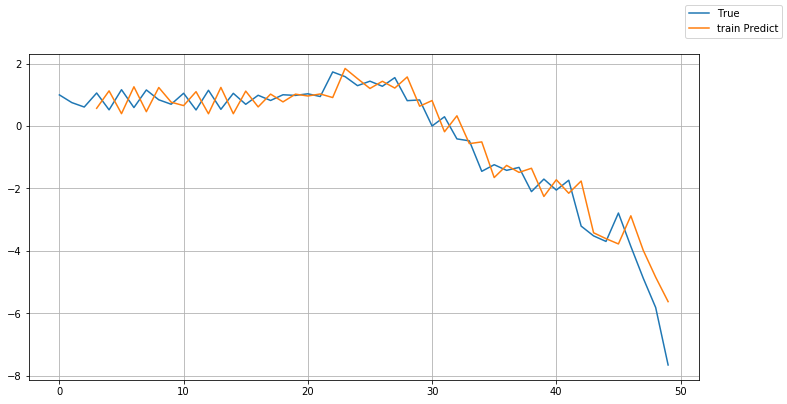

In [23]:
#check 1st values
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(scaler.inverse_transform(dataset)[:50], label= 'True' )
plt.plot(trainPredictPlot[:50], label= 'train Predict')
# ax.plot(testPredictPlot[:5], label= 'test Predict')
ax.grid(True)
fig.legend()


# Experiments 
## Performace on another House

In [24]:
#set up using house 1
dataframe1 = housing_data[1]['grid']
dataset1 = np.matrix(dataframe1.values).transpose()
dataset1 = dataset1.astype('float32')
dataset1 = scaler.fit_transform(dataset1)

In [25]:

#predict on new housing data
house1X, house1Y = create_dataset(dataset1, look_back)
house1X = house1X.reshape(house1X.shape[0], house1X.shape[1],1)
house1Predict = model.predict(house1X)

house1Predict = scaler.inverse_transform(house1Predict)
house1Y = scaler.inverse_transform([house1Y])



In [35]:
#score, closest to 0 the better
train1Score = math.sqrt(mean_squared_error(house1Y[0], house1Predict[:,0]))
print('Train Score: %.2f RMSE' % (train1Score))

Train Score: 0.43 RMSE


ValueError: Found input variables with inconsistent numbers of samples: [1, 17661]

In [27]:
#plot set
house1PredictPlot = np.empty_like(dataset1)
house1PredictPlot[:, :] = np.nan
house1PredictPlot[look_back:len(house1Predict)+look_back, :] = house1Predict

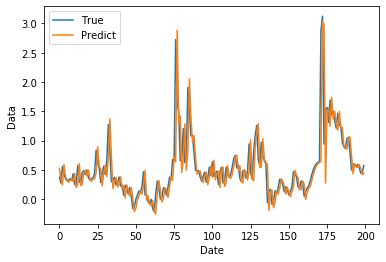

In [28]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset1)[-200:], label= 'True' )
plt.plot(house1PredictPlot[-200:], label= 'Predict')
# plt.plot(testPredictPlot, label= 'test Predict')
plt.xlabel('Date')
plt.ylabel('Data')
plt.legend()
plt.show()


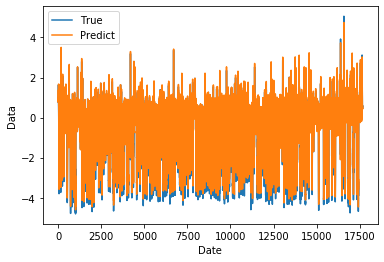

In [29]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset1), label= 'True' )
plt.plot(house1PredictPlot, label= 'Predict')
# plt.plot(testPredictPlot, label= 'test Predict')
plt.xlabel('Date')
plt.ylabel('Data')
plt.legend()
plt.show()

In [30]:
dataframe10 = housing_data[1]

In [33]:
housing_data[1]['local_15min'].values[104]

numpy.datetime64('2019-05-02T02:00:00.000000000')